Importing Tensorflow, NP, OS, PIL

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_addons as tfa

import wandb
from wandb.keras import WandbCallback

wandb.init(project="ClassifyGuns")

# To run only on CPU:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

# config = wandb.config
# config.learning_rate = 0.01

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: html1011 (use `wandb login --relogin` to force relogin)
C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Getting Data

In [2]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

data_dir = pathlib.Path("./Dataset Classification")

GPUs Available:  []


In [3]:
image_count = len(list(data_dir.glob("*/*.jp*g")))
print(image_count)

data_dir

11375


WindowsPath('Dataset Classification')

Visualizing Data!

In [4]:
guns = list(data_dir.glob('Guns/*'))
# print(guns)
for i in range(0, 5):
    val = PIL.Image.open(str(guns[i]))
    val.show()

In [5]:
no_guns = list(data_dir.glob('No Guns/*'))

for i in range(0, 5):
    val = PIL.Image.open(str(no_guns[i]))
    val.show()

Load Data!

In [15]:
batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)



Found 11380 files belonging to 2 classes.
Using 9104 files for training.
Found 11380 files belonging to 2 classes.
Using 2276 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Guns', 'No Guns']


Data Augmentaton

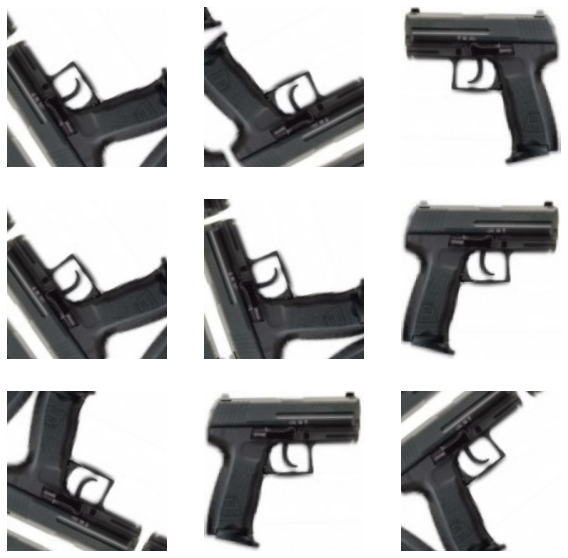

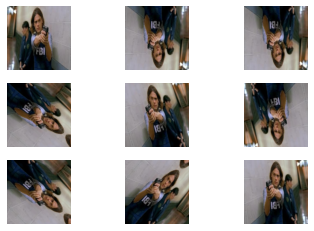

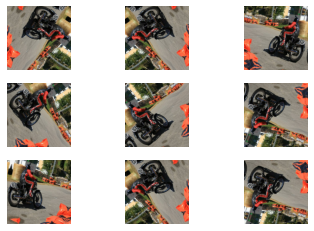

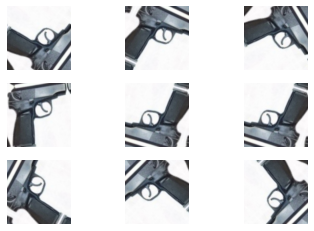

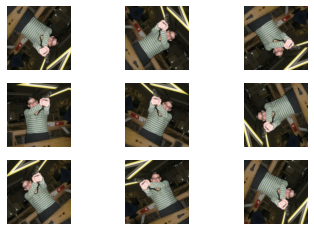

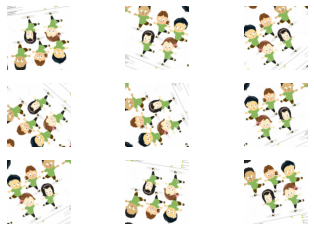

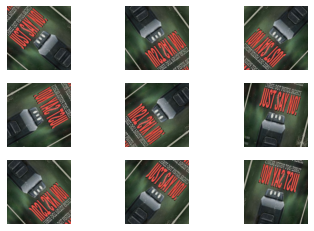

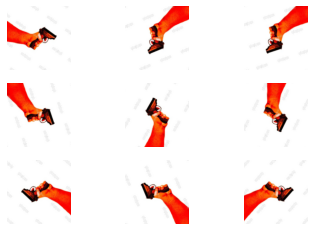

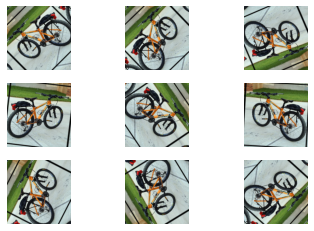

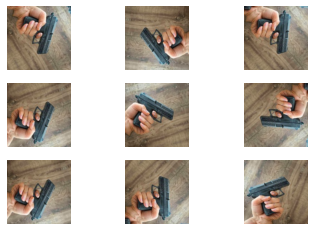

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_width, img_height, 3)),
  layers.RandomRotation(0.2),
])

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for ii in range(10):
        for i in range(9):
            # For the first image, show what happens after data augmentation
            augmented_images = data_augmentation(tf.expand_dims(images[ii], 0))

            ax = plt.subplot(3, 3, i+1)
            plt.imshow(augmented_images[0])
            plt.axis("off")
        plt.show()

# Time to apply to dataset
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

augment_train_ds = prepare(train_ds, shuffle=True, augment=True)
augment_val_ds = prepare(val_ds)

Visualizing Dataset!

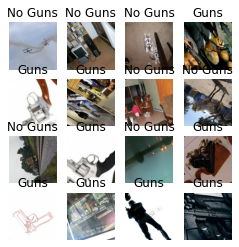

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
for images, labels in augment_train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [27]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())
    break

(64, 224, 224, 3)
(64,)
[1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1
 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0]


Configure for Performance!

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the Data

In [29]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [63]:
# Wandb stuff
import wandb
from wandb.keras import WandbCallback

wandb.init(project="ClassifyGuns")
config = wandb.config

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Create the Neural Network!

In [35]:
num_classes = len(class_names)

# MODEL 1
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation="sigmoid")
])
# model.summary()

# Model 3
# model = Sequential([
#     layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
#     layers.Conv2D(16, 3, padding="same", activation="relu"),
#     layers.Conv2D(16, 1, padding="same", activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding="same", activation="relu"),
#     layers.Conv2D(32, 1, padding="same", activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding="same", activation="relu"),
#     layers.Conv2D(64, 1, padding="same", activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, padding="same", activation="relu"),
#     layers.Conv2D(128, 1, padding="same", activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(256, 3, padding="same", activation="relu"),
#     layers.MaxPooling2D(),
#     layers.Conv2D(256, 3, padding="same", activation="relu"),
#     layers.Conv2D(256, 1, padding="same", activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Flatten(),
#     layers.Dense(1000, activation='relu'),
#     layers.Dense(num_classes)
# ])
# model.summary()

# Model 4: MobileNet
# Train on augmented data

# model = tf.keras.Sequential([
#     tf.keras.applications.mobilenet.MobileNet(
#       input_shape=(img_width, img_height, 3), alpha=1.0, depth_multiplier=1, dropout=0.005,
#       include_top=True, weights="imagenet", input_tensor=None, pooling=None, classifier_activation='softmax'
#   ),
#   layers.Flatten(),
#   layers.Dense(num_classes)
# ])

Data Augmentation

Compile the Neural Network!

In [36]:
# Save model
checkpoint_path = "imagenet_dropout_customweights/1.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=3*320)


model.build((None, img_width, img_height, 3))
tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer="RMSProp",
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy", "mse"])
     #tfa.metrics.F1Score(num_classes=num_classes, average='macro'),
                           #tfa.metrics.FBetaScore(beta=2.0, num_classes=num_classes, average='macro')])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                      

tf.Tensor(143, shape=(), dtype=int64)
(64, 224, 224, 3) (64,)


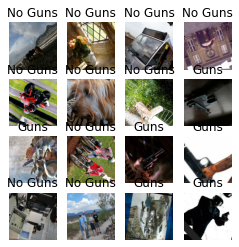

In [44]:
print(augment_train_ds.__len__())

for step, element in augment_train_ds.take(1):
    print(step.shape, element.shape)
    plt.figure(figsize=(4, 4))
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(step[i])
        plt.axis("off")
        plt.title(class_names[element[i]])
    

In [45]:
epochs = 15

history = model.fit(
  augment_train_ds,
  validation_data=augment_val_ds,
  epochs=epochs,
  callbacks=[cp_callback, tf.keras.callbacks.ReduceLROnPlateau(), WandbCallback()]
)

Epoch 1/15
134/143 [===========================>..] - ETA: 1:58 - loss: 0.6770 - accuracy: 0.6182 - mse: 0.2548

KeyboardInterrupt: 

Training!!!!

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
# 232.129
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

Reading 31 images...


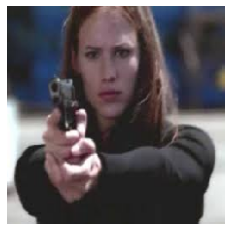

tf.Tensor([0.5175831  0.48241684], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.41s


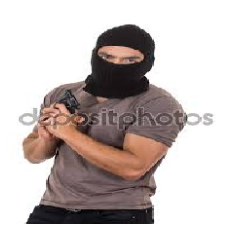

tf.Tensor([0.5194422  0.48055777], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.94 percent confidence.
Time to predict: 0.03s


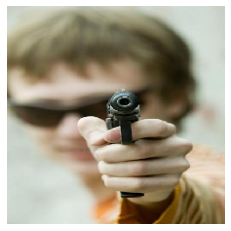

tf.Tensor([0.5175704  0.48242965], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.03s


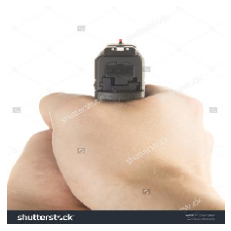

tf.Tensor([0.5185615  0.48143855], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.86 percent confidence.
Time to predict: 0.03s


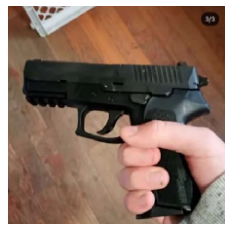

tf.Tensor([0.5176626  0.48233745], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.77 percent confidence.
Time to predict: 0.03s


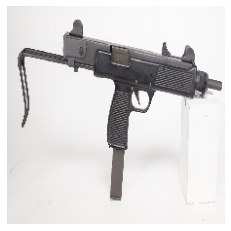

tf.Tensor([0.5205111  0.47948885], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 52.05 percent confidence.
Time to predict: 0.03s


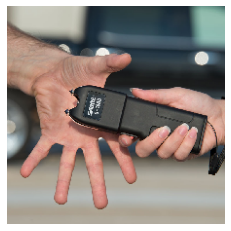

tf.Tensor([0.49453935 0.5054607 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 50.55 percent confidence.
Time to predict: 0.03s


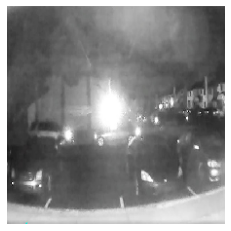

tf.Tensor([0.51758343 0.4824166 ], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.04s


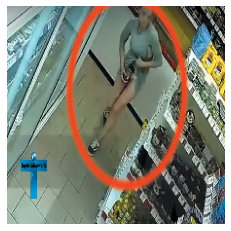

tf.Tensor([0.487289 0.512711], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 51.27 percent confidence.
Time to predict: 0.03s


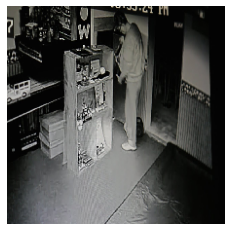

tf.Tensor([0.47615725 0.5238428 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 52.38 percent confidence.
Time to predict: 0.03s


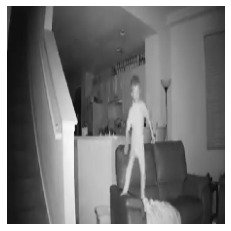

tf.Tensor([0.5175866  0.48241335], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.04s


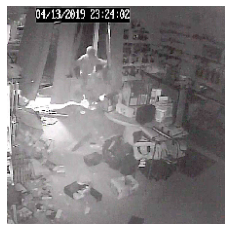

tf.Tensor([0.51594836 0.4840517 ], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.59 percent confidence.
Time to predict: 0.03s


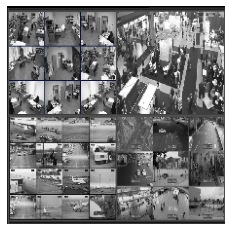

tf.Tensor([0.5125792 0.4874208], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.26 percent confidence.
Time to predict: 0.04s


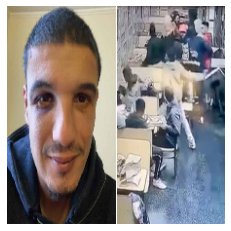

tf.Tensor([0.5154231  0.48457685], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.54 percent confidence.
Time to predict: 0.03s


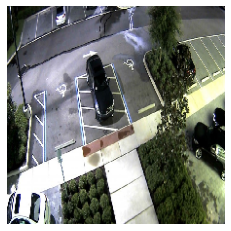

tf.Tensor([0.48728698 0.5127131 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 51.27 percent confidence.
Time to predict: 0.03s


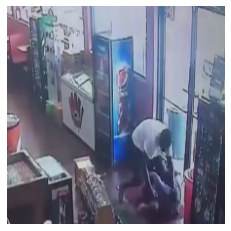

tf.Tensor([0.51758206 0.4824179 ], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.03s


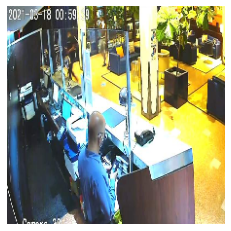

tf.Tensor([0.5131212 0.4868788], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.31 percent confidence.
Time to predict: 0.04s


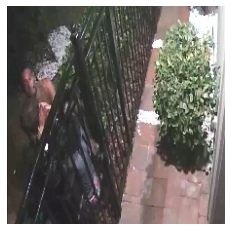

tf.Tensor([0.5174676  0.48253238], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.75 percent confidence.
Time to predict: 0.03s


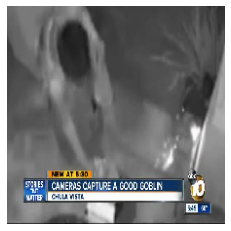

tf.Tensor([0.517597   0.48240295], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.05s


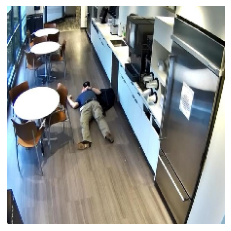

tf.Tensor([0.48730472 0.51269525], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 51.27 percent confidence.
Time to predict: 0.03s


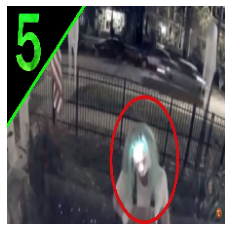

tf.Tensor([0.5175831  0.48241684], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.76 percent confidence.
Time to predict: 0.04s


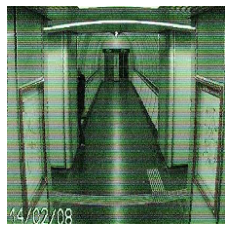

tf.Tensor([0.52072364 0.47927633], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 52.07 percent confidence.
Time to predict: 0.43s


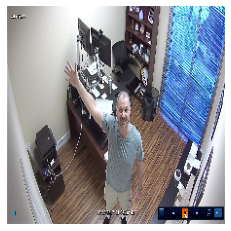

tf.Tensor([0.50105006 0.49894997], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 50.11 percent confidence.
Time to predict: 0.03s


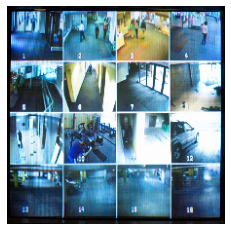

tf.Tensor([0.4946431  0.50535697], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 50.54 percent confidence.
Time to predict: 0.04s


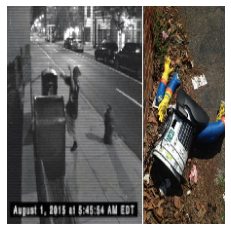

tf.Tensor([0.487323 0.512677], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 51.27 percent confidence.
Time to predict: 0.04s


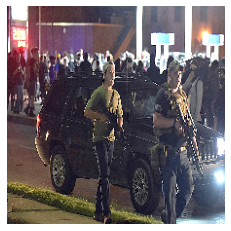

tf.Tensor([0.51313883 0.48686114], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.31 percent confidence.
Time to predict: 0.03s


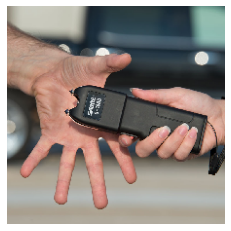

tf.Tensor([0.49453935 0.5054607 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 50.55 percent confidence.
Time to predict: 0.04s


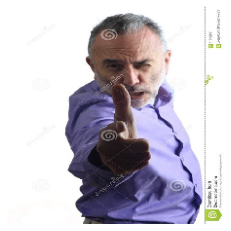

tf.Tensor([0.51452696 0.485473  ], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.45 percent confidence.
Time to predict: 0.03s


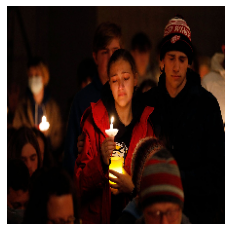

tf.Tensor([0.47616497 0.52383506], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 52.38 percent confidence.
Time to predict: 0.04s


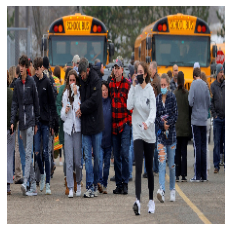

tf.Tensor([0.48745435 0.51254565], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 51.25 percent confidence.
Time to predict: 0.03s


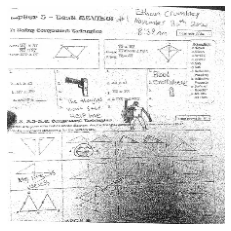

tf.Tensor([0.51097137 0.48902857], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 51.10 percent confidence.
Time to predict: 0.04s


In [34]:
# gun_url = "https://nypost.com/wp-content/uploads/sites/2/2021/08/kyle-rittenhouse-03.jpg?quality=90&strip=all&w=1535"
# gun_path = tf.keras.utils.get_file('marching', origin=gun_url)
# print(gun_path)
import time

gun_paths = list(pathlib.Path("Validation_Test").glob("*"))
print(F"Reading {len(gun_paths)} images...")

for gun_path in gun_paths:
    img = tf.keras.utils.load_img(
        gun_path, target_size=(img_height, img_width)
    )

    plt.imshow(img)
    plt.axis("off")
    plt.show()

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    start = time.time()
    predictions = model.predict(img_array)

    score = tf.nn.softmax(predictions[0])
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print("Time to predict: {:.2f}s".format(time.time() - start))